In [1]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt



In [2]:
def read_and_clean_dataframe(file_path):
    df = pd.read_parquet(file_path)
    print(f"Total records: {df.dropOff_datetime.count()}")
    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    count_1 = df.duration.count()
    print(f"Average duration : {df.duration.describe()['mean']}")
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    count_2 = df.duration.count()
    print(f"Dropped: {count_1 - count_2}")
    
    df['PUlocationID'].fillna(-1, inplace=True)
    df['DOlocationID'].fillna(-1, inplace=True)

    na_percent = df[df['PUlocationID']==-1]["PUlocationID"].count()*100/df['PUlocationID'].count()

    print(f"N/A percentage: {na_percent:.2f}%")
    return df

In [3]:
df_train = read_and_clean_dataframe('data/fhv_tripdata_2021-01.parquet')

Total records: 1154112
Average duration : 19.167224093791006
Dropped: 44286
N/A percentage: 83.53%


In [4]:
df_valid = read_and_clean_dataframe('data/fhv_tripdata_2021-02.parquet')

Total records: 1037692
Average duration : 20.706986225199763
Dropped: 47579
N/A percentage: 85.71%


In [5]:
categorical = ['PUlocationID', 'DOlocationID']
df_train[categorical] = df_train[categorical].astype(str)
train_dicts = df_train[categorical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

df_valid[categorical] = df_valid[categorical].astype(str)
valid_dicts = df_valid[categorical].to_dict(orient='records')

X_valid = dv.transform(valid_dicts)


In [6]:
print(f"Dimensionality after OHE: {X_train.shape[1]}")

Dimensionality after OHE: 525


In [7]:
target = 'duration'
y_train = df_train[target].values

y_valid = df_valid[target].values

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [9]:
y_pred = lr.predict(X_train)
y_pred_valid = lr.predict(X_valid)

In [10]:
def plot(y_train, y_pred):
    sns.distplot(y_pred, label="prediction")
    sns.distplot(y_train, label="actual")
    plt.legend()

Evaluation graph


/home/dulanj/miniconda3/envs/mlops/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/dulanj/miniconda3/envs/mlops/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


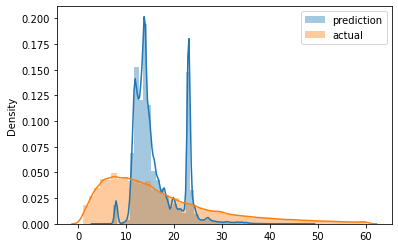

In [11]:
# print("Training graph")
# plot(y_train, y_pred)
print("Evaluation graph")
plot(y_valid, y_pred_valid)

In [12]:
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(y_train, y_pred, squared=False)
print(f"Root mean squared error for training: {rmse}")
rmse = mean_squared_error(y_valid, y_pred_valid, squared=False)
print(f"Root mean squared error for validation: {rmse}")

Root mean squared error for training: 10.528519395347283
Root mean squared error for validation: 11.014287883358007
